# Product Classifier [Train model notebook]

## Author: Luis Eduardo Ferro Diez, <a href="mailto:luis.ferro1@correo.icesi.edu.co">luis.ferro1@correo.icesi.edu.co</a>

This notebook contains the run as-is code necessary to compute the necessary elements of the project.

In [1]:
reviews_path = "/media/ohtar10/Adder-Storage/datasets/amazon/rev_prod_documents/10m"
n = 1000

## Step 1 - Read data as-is

In [2]:
import pandas as pd

reviews = pd.read_parquet(reviews_path, engine="pyarrow")
reviews.head()

,categories,document
0,"Technology, Electronics & Accessories",Hifonics ZRX2000.1D Car Amplifier\nHifonics Ze...
1,"Technology, Electronics & Accessories",3x Nokia Lumia 521 (TMobile) Premium AntiGlare...
2,Home & Kitchen,Cook! Collection Solid Color Jacquard Terry Ki...
3,"Clothing, Shoes & Jewelry",NCAA VCU Rams Ash Distressed Logo Vintage Tshi...
4,Health & Personal Care,1Pack of 3 Cavilon Durable Barrier Cream MMM3...


In [4]:
documents = reviews[:n]

## Step 1.1 - Transform the data to count documents per category
We have documents that can have multiple categories, we need a transformer that explode these cases so we can count the number of documents per category

In [11]:
from sklearn.base import BaseEstimator, TransformerMixin

class MultiValueColumnExpander(BaseEstimator, TransformerMixin):
    
    def __init__(self, expand_column, value_split_char=";"):
        self.expand_column = expand_column
        self.value_split_char = value_split_char
        
    def fit(self, X, y=None):
        return self # do nothing
    
    def transform(self, X, y=None):
        data = X.copy()
        split_fn = lambda x: x.split(";")
        data[self.expand_column] = data[self.expand_column].apply(split_fn)
        return data.explode(self.expand_column)

In [12]:
col_expander = MultiValueColumnExpander(expand_column="categories", value_split_char=";")
expanded_documents = col_expander.transform(documents)
expanded_documents.head()

,categories,document
0,"Technology, Electronics & Accessories",Hifonics ZRX2000.1D Car Amplifier\nHifonics Ze...
1,"Technology, Electronics & Accessories",3x Nokia Lumia 521 (TMobile) Premium AntiGlare...
2,Home & Kitchen,Cook! Collection Solid Color Jacquard Terry Ki...
3,"Clothing, Shoes & Jewelry",NCAA VCU Rams Ash Distressed Logo Vintage Tshi...
4,Health & Personal Care,1Pack of 3 Cavilon Durable Barrier Cream MMM3...


## Step 2 - Pre-process text

In [6]:
def create_tagged_document(row):
    categories = row["categories"]
    document = row["document"]
    tagged_document = TaggedDocument(words=word_tokenize(document), tags=categories.split(";"))
    index = ["categories", "document", "tagged_document"]
    return pd.Series([categories, document, tagged_document], index=index)

In [7]:
import nltk
from sklearn.base import BaseEstimator, TransformerMixin
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.tokenize import word_tokenize

nltk.download('punkt')

class DocumentTagger(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self # Do nothing
    
    def transform(self, X, y=None):
        data = X.copy()
        return data.apply(create_tagged_document, axis=1)

[nltk_data] Downloading package punkt to /home/ohtar10/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [9]:
document_tagger = DocumentTagger()
tagged_documents = document_tagger.transform(documents)
tagged_documents.head()

,categories,document,tagged_document
0,"Technology, Electronics & Accessories",Hifonics ZRX2000.1D Car Amplifier\nHifonics Ze...,"([Hifonics, ZRX2000.1D, Car, Amplifier, Hifoni..."
1,"Technology, Electronics & Accessories",3x Nokia Lumia 521 (TMobile) Premium AntiGlare...,"([3x, Nokia, Lumia, 521, (, TMobile, ), Premiu..."
2,Home & Kitchen,Cook! Collection Solid Color Jacquard Terry Ki...,"([Cook, !, Collection, Solid, Color, Jacquard,..."
3,"Clothing, Shoes & Jewelry",NCAA VCU Rams Ash Distressed Logo Vintage Tshi...,"([NCAA, VCU, Rams, Ash, Distressed, Logo, Vint..."
4,Health & Personal Care,1Pack of 3 Cavilon Durable Barrier Cream MMM3...,"([1Pack, of, 3, Cavilon, Durable, Barrier, Cre..."


## Step 3 - Train Document Embeddings

In [10]:
from sklearn.base import BaseEstimator, TransformerMixin
from gensim.models.doc2vec import Doc2Vec, TaggedDocument


class Doc2VecWrapper(BaseEstimator, TransformerMixin):
    
    def __init__(self, document_column, tag_doc_column, lr=0.01, epochs=10, vec_size=100, alpha=0.1, min_alpha=0.0001, min_count=1, dm=0):
        self.document_column = document_column
        self.tag_doc_column = tag_doc_column
        self.lr = lr
        self.epochs = epochs
        self.vec_size = vec_size
        self.alpha = alpha
        self.min_alpha = min_alpha
        self.min_count = min_count
        self.dm = dm
    
    def fit(self, X, y=None):
        tagged_documents = X[self.tag_doc_column]
        
        d2v_model = Doc2Vec(vector_size=self.vec_size,
                           alpha=self.alpha,
                           min_alpha=self.min_alpha,
                           min_count=self.min_count,
                           dm=self.dm)
        
        d2v_model.build_vocab(tagged_documents)
        
        for epoch in range(self.epochs):
            d2v_model.train(tagged_documents,
                           total_examples=d2v_model.corpus_count,
                           epochs=d2v_model.epochs)
            d2v_model.alpha -= self.lr
            d2v_model.min_alpha = d2v_model.alpha
        self.d2v_model = d2v_model
        
        return self
    
    def transform(self, X, y=None):
        data = X.copy()
        tagged_docs = data[self.document_column].apply(word_tokenize)
        embeddings = tagged_docs.apply(self.d2v_model.infer_vector)
        data["d2v_embedding"] = embeddings
        return data
    
    def save_model(self, save_path):
        self.d2v_model.save(save_path)

In [11]:
%%time
from sklearn.pipeline import Pipeline

d2v_model = Doc2VecWrapper(document_column="document",
                          tag_doc_column="tagged_document",
                          lr=0.0002,
                          epochs=10,
                          vec_size=300,
                          alpha=0.025,
                          min_alpha=0.00025)
d2v_pipeline = Pipeline(
    [
        ("doc_tagger", DocumentTagger()),
        ("d2v_model", d2v_model)
    ]
)

document_embeddings = d2v_pipeline.fit_transform(documents)
document_embeddings.head()

CPU times: user 14.4 s, sys: 246 ms, total: 14.6 s
Wall time: 9.14 s


,categories,document,tagged_document,d2v_embedding
0,"Technology, Electronics & Accessories",Hifonics ZRX2000.1D Car Amplifier\nHifonics Ze...,"([Hifonics, ZRX2000.1D, Car, Amplifier, Hifoni...","[0.24003635, 0.3862036, -0.3143674, -0.2510423..."
1,"Technology, Electronics & Accessories",3x Nokia Lumia 521 (TMobile) Premium AntiGlare...,"([3x, Nokia, Lumia, 521, (, TMobile, ), Premiu...","[0.20093574, 0.27565536, -0.29014444, -0.35602..."
2,Home & Kitchen,Cook! Collection Solid Color Jacquard Terry Ki...,"([Cook, !, Collection, Solid, Color, Jacquard,...","[0.022177821, -0.16445465, 0.113497145, 0.0023..."
3,"Clothing, Shoes & Jewelry",NCAA VCU Rams Ash Distressed Logo Vintage Tshi...,"([NCAA, VCU, Rams, Ash, Distressed, Logo, Vint...","[-0.1603686, -0.006058366, 0.17076525, -0.1371..."
4,Health & Personal Care,1Pack of 3 Cavilon Durable Barrier Cream MMM3...,"([1Pack, of, 3, Cavilon, Durable, Barrier, Cre...","[-0.10445429, 0.027966857, -0.023352114, -0.15..."


In [12]:
d2v_model.save_model("/tmp/d2v_model.model")

## Step 4 - CNN Preprocess
In this stage we prepar the input information to be feed to the CNN model.

In [13]:
from sklearn.preprocessing import MultiLabelBinarizer
import numpy as np
import pickle

class CategoryEncoder(BaseEstimator, TransformerMixin):
    
    def __init__(self, label_column="categories"):
        self.label_column = label_column
    
    def fit(self, X, y=None):
        data = X.copy()
        categories = data[self.label_column].apply(lambda cat: cat.split(";")).values.tolist()
        category_encoder = MultiLabelBinarizer()
        category_encoder.fit(categories)
        self.category_encoder = category_encoder
        return self
    
    def transform(self, X, y=None):
        data = X.copy()
        categories = data[self.label_column].apply(lambda cat: cat.split(";")).values.tolist()
        encoded_categories = self.category_encoder.transform(categories)
        encoded_categories = [arr for arr in encoded_categories]
        data["encoded_category"] = encoded_categories
        return data
    
    def save_model(self, save_path):
        with open(save_path, 'wb') as model_file:
            pickle.dump(self.category_encoder, model_file)

In [14]:
cat_encoder = CategoryEncoder()
doc_embeddings_encoded_cats = cat_encoder.fit_transform(document_embeddings)
doc_embeddings_encoded_cats.head()

,categories,document,tagged_document,d2v_embedding,encoded_category
0,"Technology, Electronics & Accessories",Hifonics ZRX2000.1D Car Amplifier\nHifonics Ze...,"([Hifonics, ZRX2000.1D, Car, Amplifier, Hifoni...","[0.24003635, 0.3862036, -0.3143674, -0.2510423...","[0, 0, 0, 0, 0, 0, 0, 0, 1, 0]"
1,"Technology, Electronics & Accessories",3x Nokia Lumia 521 (TMobile) Premium AntiGlare...,"([3x, Nokia, Lumia, 521, (, TMobile, ), Premiu...","[0.20093574, 0.27565536, -0.29014444, -0.35602...","[0, 0, 0, 0, 0, 0, 0, 0, 1, 0]"
2,Home & Kitchen,Cook! Collection Solid Color Jacquard Terry Ki...,"([Cook, !, Collection, Solid, Color, Jacquard,...","[0.022177821, -0.16445465, 0.113497145, 0.0023...","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0]"
3,"Clothing, Shoes & Jewelry",NCAA VCU Rams Ash Distressed Logo Vintage Tshi...,"([NCAA, VCU, Rams, Ash, Distressed, Logo, Vint...","[-0.1603686, -0.006058366, 0.17076525, -0.1371...","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0]"
4,Health & Personal Care,1Pack of 3 Cavilon Durable Barrier Cream MMM3...,"([1Pack, of, 3, Cavilon, Durable, Barrier, Cre...","[-0.10445429, 0.027966857, -0.023352114, -0.15...","[0, 0, 1, 0, 0, 0, 0, 0, 0, 0]"


In [15]:
cat_encoder.save_model("/tmp/product_category_encoder.sav")

## Step 4 - Train the CNN

In [18]:
import tensorflow as tf
from tensorflow.python.client import device_lib
from keras import backend as K

s_config = tf.ConfigProto()
#s_config.gpu_options.allow_growth = True
s_config.gpu_options.per_process_gpu_memory_fraction = 0.6
tf.keras.backend.set_session(tf.Session(config=s_config))

In [19]:
from keras.layers import Input, Embedding, Bidirectional, Dense, Conv1D, Flatten, MaxPool1D, concatenate, BatchNormalization, Dropout, SpatialDropout1D
from keras.models import Model
from keras import regularizers
from keras.callbacks import EarlyStopping

class ProductsCNN(BaseEstimator, TransformerMixin):
    
    def __init__(self, features_column, label_column, classes, 
                 vec_size=100, 
                 epochs=100, 
                 batch_size=1000,
                 validation_split=0.2):
        self.features_column = features_column
        self.label_column = label_column
        self.vec_size = vec_size
        self.classes = classes
        self.epochs = epochs
        self.batch_size = batch_size
        self.validation_split = validation_split
        
    
    def __build_ann_architecture(self):
        # Define the inputs
        embedding_input = Input(shape=(self.vec_size,1), dtype='float32', name='comment_text')

        # Define convolutional layers
        conv = Conv1D(64, 3, activation='tanh', input_shape=(self.vec_size,), kernel_regularizer=regularizers.l2())(embedding_input)
        conv = MaxPool1D(2, strides=None, padding='valid')(conv)
        conv = Conv1D(128, 3, activation='tanh')(conv)
        conv = SpatialDropout1D(0.2)(conv)
        conv = MaxPool1D(2, strides=None, padding='valid')(conv)
        conv = Conv1D(128, 3, activation='tanh')(conv)
        conv = MaxPool1D(2, strides=None, padding='valid')(conv)
        conv = SpatialDropout1D(0.1)(conv)
        conv = Conv1D(64, 3, activation='tanh')(conv)
        conv = MaxPool1D(2, strides=None, padding='valid')(conv)
        conv_output = Flatten()(conv)


        # Define dense layers
        # minimize the dense layers - maybe add one of 64
        x = Dense(128, activation='relu')(conv_output)
        x = Dropout(0.5)(x)

        #And finally make the predictions using the previous layer as input
        main_output = Dense(self.classes, activation='softmax', name='prediction')(x)

        ann_model = Model(inputs=embedding_input, outputs=main_output)
        ann_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
        
        self.ann_model = ann_model
    
    def fit(self, X, y=None):
        self.__build_ann_architecture()
        X_train = X[self.features_column].values
        X_train = np.array([e for e in X_train])
        y_true = X[self.label_column].values
        y_true = np.array([l for l in y_true])
        X_rs = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
        early_stopping = EarlyStopping(monitor='val_loss', patience=10, min_delta=1e-7, restore_best_weights=True)
        history = self.ann_model.fit(X_rs, y_true, 
                                     epochs=self.epochs, 
                                     batch_size=self.batch_size, 
                                     validation_split=self.validation_split, 
                                     callbacks=[early_stopping])
        self.history = history
        return self
    
    def transform(self, X, y=None):
        data = X.copy()
        features = data[self.features_column].values
        features = np.array([e for e in features])
        features = features.reshape(features.shape[0], features.shape[1], 1)
        predictions = self.ann_model.predict(features)
        predictions = [p for p in predictions]
        data["predictions"] = predictions
        return data
    
    def save_model(self, save_path, name=None):
        if not name:
            name = "product_cnn"
        definition_path = f"{save_path}/{name}-def.yaml"
        weights_path = f"{save_path}/{name}-weights.h5"
        
        ann_model_definition = self.ann_model.to_yaml()
        
        with open(definition_path, 'w') as file:
            file.write(ann_model_definition)

        self.ann_model.save_weights(weights_path)

In [20]:
%%time
classes = cat_encoder.category_encoder.classes_.shape[0]
products_cnn = ProductsCNN(features_column="d2v_embedding", 
                           label_column="encoded_category", 
                           classes=classes, 
                           vec_size=300)
docs_with_predictions = products_cnn.fit_transform(doc_embeddings_encoded_cats)
docs_with_predictions.head()

Train on 800 samples, validate on 200 samples
Epoch 1/100
800/800 [==============================] - 2s 3ms/step - loss: 2.3233 - acc: 0.1363 - val_loss: 2.2372 - val_acc: 0.2450
Epoch 2/100
800/800 [==============================] - 0s 40us/step - loss: 2.2512 - acc: 0.3150 - val_loss: 2.1329 - val_acc: 0.2400
Epoch 3/100
800/800 [==============================] - 0s 39us/step - loss: 2.1575 - acc: 0.3313 - val_loss: 2.0027 - val_acc: 0.2400
Epoch 4/100
800/800 [==============================] - 0s 40us/step - loss: 2.0565 - acc: 0.3313 - val_loss: 1.9002 - val_acc: 0.2400
Epoch 5/100
800/800 [==============================] - 0s 39us/step - loss: 1.9874 - acc: 0.3325 - val_loss: 1.8360 - val_acc: 0.4900
Epoch 6/100
800/800 [==============================] - 0s 40us/step - loss: 1.9768 - acc: 0.3288 - val_loss: 1.7658 - val_acc: 0.5650
Epoch 7/100
800/800 [==============================] - 0s 40us/step - loss: 1.9055 - acc: 0.3663 - val_loss: 1.7302 - val_acc: 0.5650
Epoch 8/100
800/8

,categories,document,tagged_document,d2v_embedding,encoded_category,predictions
0,"Technology, Electronics & Accessories",Hifonics ZRX2000.1D Car Amplifier\nHifonics Ze...,"([Hifonics, ZRX2000.1D, Car, Amplifier, Hifoni...","[0.24003635, 0.3862036, -0.3143674, -0.2510423...","[0, 0, 0, 0, 0, 0, 0, 0, 1, 0]","[8.371304e-05, 9.8686305e-06, 0.0016424534, 0...."
1,"Technology, Electronics & Accessories",3x Nokia Lumia 521 (TMobile) Premium AntiGlare...,"([3x, Nokia, Lumia, 521, (, TMobile, ), Premiu...","[0.20093574, 0.27565536, -0.29014444, -0.35602...","[0, 0, 0, 0, 0, 0, 0, 0, 1, 0]","[2.2891764e-09, 2.7801683e-08, 1.9210213e-06, ..."
2,Home & Kitchen,Cook! Collection Solid Color Jacquard Terry Ki...,"([Cook, !, Collection, Solid, Color, Jacquard,...","[0.022177821, -0.16445465, 0.113497145, 0.0023...","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0]","[7.6058717e-07, 5.2648545e-08, 6.879568e-07, 8..."
3,"Clothing, Shoes & Jewelry",NCAA VCU Rams Ash Distressed Logo Vintage Tshi...,"([NCAA, VCU, Rams, Ash, Distressed, Logo, Vint...","[-0.1603686, -0.006058366, 0.17076525, -0.1371...","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0]","[1.5200509e-05, 0.9999765, 3.0271233e-06, 1.35..."
4,Health & Personal Care,1Pack of 3 Cavilon Durable Barrier Cream MMM3...,"([1Pack, of, 3, Cavilon, Durable, Barrier, Cre...","[-0.10445429, 0.027966857, -0.023352114, -0.15...","[0, 0, 1, 0, 0, 0, 0, 0, 0, 0]","[6.277858e-10, 1.4940024e-05, 0.99973077, 9.87..."


In [21]:
products_cnn.save_model(save_path="/tmp", name="cnn_test")

In [25]:
import matplotlib.pyplot as plt

def plot_history(cnn, 
                 acc='acc', 
                 val_acc='val_acc', 
                 loss='loss', 
                 val_loss='val_loss',
                 save_path=None):
    fig = plt.figure(figsize = (16, 8))
    plt.subplot(1, 2, 1)
    plt.title('Accuracy in training Vs validation', fontsize=16)
    plt.ylabel('Accuracy', fontsize=14)
    plt.xlabel('Epoch', fontsize=14)
    plt.plot(cnn.history[acc], 'r')
    plt.plot(cnn.history[val_acc], 'b')
    plt.legend(['training', 'validation'], fontsize=14)
    
    plt.subplot(1, 2, 2)
    plt.title('Loss in training Vs validation', fontsize=16)
    plt.ylabel('Loss', fontsize=14)
    plt.xlabel('Epoch', fontsize=14)
    plt.plot(cnn.history[loss], 'r')
    plt.plot(cnn.history[val_loss], 'b')
    plt.legend(['training', 'validation'], fontsize=14)
    
    if save_path:
        plt.savefig(save_path, bbox_inches="tight")
    else:
        plt.show()

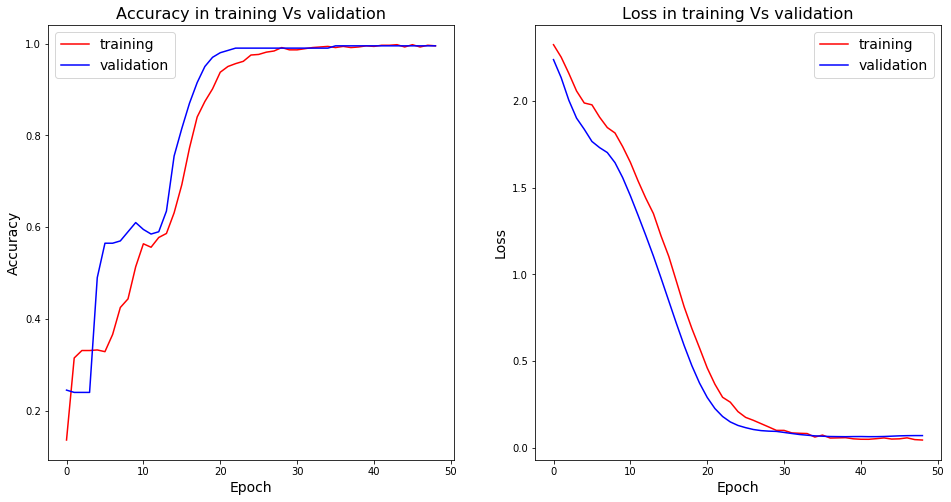

In [26]:
plot_history(products_cnn.history, 
             acc='acc', 
             val_acc='val_acc', 
             loss='loss', 
             val_loss='val_loss',
             save_path="./cnn_train_history.png")